In [40]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, Matern

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# so warnings dont clutter notebook
import warnings
warnings.filterwarnings('ignore')

- Consider data points $(x_t, y_t)$ for $t \in {1...n}$. 
- Forst describe the retalyionshiop between $x$ and $y$, then use this to predict $y^*$ gievn unseen $x^*$.
- In this case we will consider uni-variate time-series, where $x$ is composed of the past $k$ timesteps $x_{t-k} \to x_t$.

In [41]:
# Define the time variable t
n_samples = 100
t = np.arange(n_samples)
data = pd.DataFrame({'t': t})

# Curate the fluctuating variable over the time-series (i.e. return)
asset = 'ETH/USD'
pair = asset.replace('/', '-')
df = pd.read_csv(f'../Datasets/Data/data_{pair}.csv')

closing = df.Close
log_returns = np.log(closing) - np.log(closing.shift(1))
log_returns.dropna(inplace=True)
abs_returns = np.abs(np.array(log_returns))

# positive and negative returns
returns_pos = np.array(log_returns[log_returns >= 0])
returns_neg = np.abs(np.array(log_returns[log_returns < 0]))

print(f"max no. absolute returns in dataset: {abs_returns.shape[0]}")

np.random.seed(22)
rand_index = np.random.randint(0, abs_returns.shape[0] - n_samples)
rand_index_pos = np.random.randint(0, returns_pos.shape[0] - n_samples)
rand_index_neg = np.random.randint(0, returns_neg.shape[0] - n_samples)

data['y'] = abs_returns[rand_index: rand_index + n_samples]
data['y_+'] = returns_pos[rand_index_pos: rand_index_pos + n_samples]
data['y_-'] = returns_neg[rand_index_neg: rand_index_neg + n_samples]
data.head()

max no. absolute returns in dataset: 2591


,t,y,y_+,y_-
0,0,0.001131,0.006736,0.000322
1,1,0.000592,0.000829,0.000752
2,2,0.000431,0.000107,0.001506
3,3,0.000943,0.000295,0.000833
4,4,0.002341,0.003156,0.001857


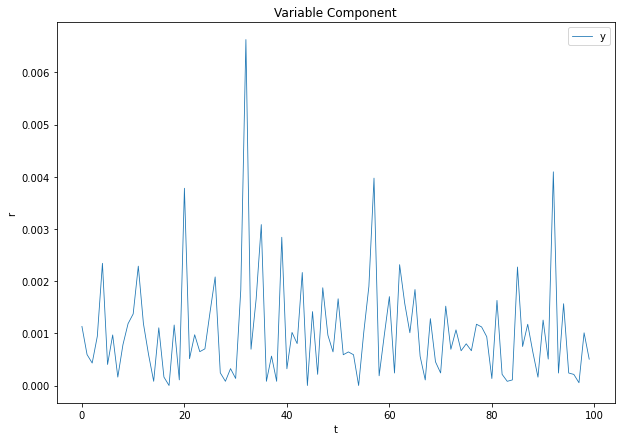

In [42]:
# plot the time-series
fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(x='t', y='y', data=data, label='y', ax=ax, linewidth=0.8) 

ax.set(title='Variable Component', xlabel='t', ylabel='r')
ax.legend()

In [43]:
# split data into training and testing sets
# X = times; y = return
X = data['t'].values.reshape(n_samples, 1)
y = data['y'].values.reshape(n_samples, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

[Text(0.5, 1.0, 'Train test split of variable'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, 'r')]

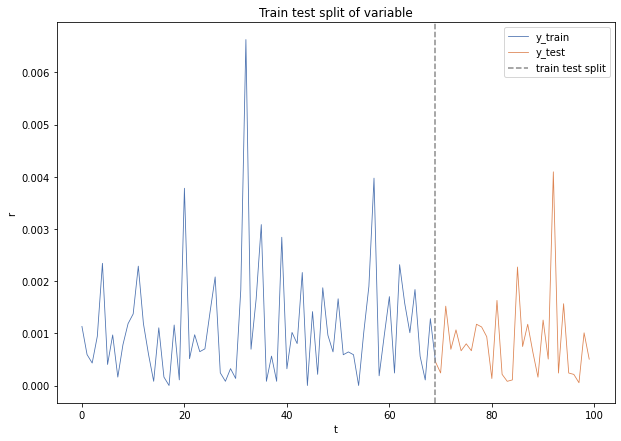

In [44]:
# plot the split datasets
fig, ax = plt.subplots(figsize=(10, 7))

X_test_extended = np.append(X_train[-1], X_test.flatten())
y_test_extended = np.append(y_train[-1], y_test.flatten())

sns.lineplot(x=X_train.flatten(), y=y_train.flatten(), color=sns.color_palette(palette='deep')[0], ax=ax, linewidth=0.8, label='y_train') 
sns.lineplot(x=X_test_extended, y=y_test_extended, color=sns.color_palette(palette='deep')[1], ax=ax, linewidth=0.8, label='y_test') 

ax.axvline(x=X_train.flatten()[-1], color=sns.color_palette(palette='deep')[7], linestyle='--', label='train test split')

ax.legend()
ax.set(title='Train test split of variable', xlabel='t', ylabel='r')

In [45]:
# define the kernel of the gaussian process model

# WhiteKernel models the noise of the signal as iid
# 1 hyperparameter `noise_level`
whitekernel = WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-2, 1.0))

# ConstantKernel scales the magnitude of the kernel by modifying the mean of the Gaussian process
# 1 hyperparam `constant_value`
constantkernel = ConstantKernel(constant_value=1e-5, constant_value_bounds=(1e-5, 1e5))

# ESSKernel allows the modelling of repeating functions
# 2 hyperparams `length_scale` and `periodicity`
esskernel =  ExpSineSquared(length_scale=1e-5, length_scale_bounds=(1e-7, 1e1), periodicity=55, periodicity_bounds=(45, 65))

# sum/product kernel
kernel = whitekernel + constantkernel * esskernel

Gaussian Process model hhyperparameters:
- `alpha` = variance of iid noise added to labels
- `normalise_y` = constant mean function used (False => zero mean; True => mean of training data)
- `n_restarts_optimizer` = number of different initialisations to try during tuning
- `optimiser` = default is given

In [46]:
# specify Gaussian model hyperparameters
alpha = 0.0
normalise_y = True
n_restarts_optimiser = 10
optimiser = 'fmin_l_bfgs_b'

# initialise the gaussian process regression model
gp = GaussianProcessRegressor(
    kernel=kernel,
    optimizer=optimiser,
    n_restarts_optimizer=n_restarts_optimiser,
    normalize_y=normalise_y,
    alpha=alpha
)

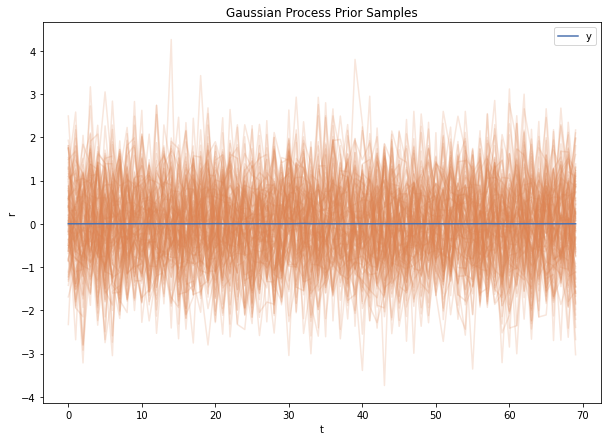

In [47]:
# sample from prior distribution and compare it to our observed training data
prior_samples = gp.sample_y(X=X_train, n_samples=100)
x_plot = X_train[..., 0].copy()

fig, ax = plt.subplots(figsize=(10, 7))

for i in range(100):
    sns.lineplot(x=x_plot, y=prior_samples[:, i], color=sns.color_palette(palette='deep')[1], alpha=0.2, ax=ax)

sns.lineplot(x=x_plot, y=y_train[:, 0], color=sns.color_palette(palette='deep')[0], ax=ax, label='y')
ax.set(title='Gaussian Process Prior Samples', xlabel='t', ylabel='r')
ax.legend()

In [48]:
# tune model hyperparameters through MLE
gp.fit(X_train, y_train)
print("Optimised kernel params: \n", pd.Series(gp.kernel_.get_params()))

Optimised kernel params: 
 k1                                                  WhiteKernel(noise_level=0.236)
k2                               0.898**2 * ExpSineSquared(length_scale=0.0159,...
k1__noise_level                                                           0.235954
k1__noise_level_bounds                                                 (0.01, 1.0)
k2__k1                                                                    0.898**2
k2__k2                           ExpSineSquared(length_scale=0.0159, periodicit...
k2__k1__constant_value                                                    0.806633
k2__k1__constant_value_bounds                                    (1e-05, 100000.0)
k2__k2__length_scale                                                      0.015927
k2__k2__periodicity                                                      63.957213
k2__k2__length_scale_bounds                                          (1e-07, 10.0)
k2__k2__periodicity_bounds                                  

In [49]:
# make predictions over entire dataset, returning the predicted instances and covariance
y_pred, y_cov = gp.predict(X, return_cov=True)

# compute the predictions standard deviation (from which we can get the confidence interval)
y_std = np.sqrt(y_cov.diagonal())

# store prediction data
data['y_pred'] = y_pred
data['y_std'] = y_std
data['pred_upper_bound'] = data['y_pred'] + 2 * data['y_std']
data['pred_lower_bound'] = data['y_pred'] - 2 * data['y_std']

[Text(0.5, 1.0, 'Predictions'), Text(0.5, 0, 't'), Text(0, 0.5, 'r')]

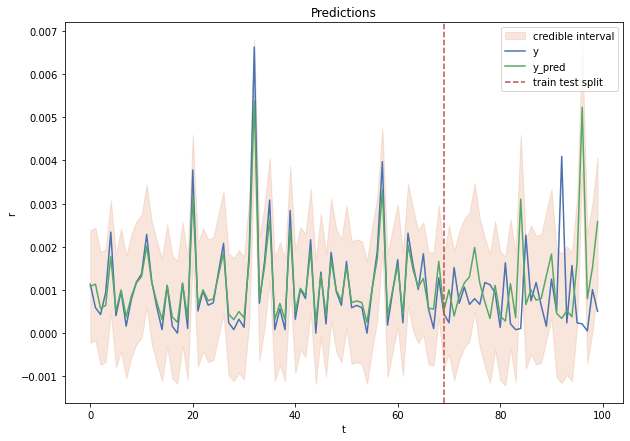

In [50]:
# plot the predictions
fig, ax = plt.subplots(figsize=(10, 7))

ax.fill_between(
    x=data['t'],
    y1=data['pred_upper_bound'],
    y2=data['pred_lower_bound'],
    color=sns.color_palette(palette='deep')[1],
    alpha=0.2,
    label='credible interval'
)

sns.lineplot(x='t', y='y', data=data, color=sns.color_palette(palette='deep')[0], ax=ax, label='y')
sns.lineplot(x='t', y='y_pred', data=data, color=sns.color_palette(palette='deep')[2], ax=ax, label='y_pred')

ax.axvline(X_train.shape[0] - 1, color=sns.color_palette(palette='deep')[3], linestyle='--', label='train test split')
ax.legend()
ax.set(title='Predictions', xlabel='t', ylabel='r')

In [51]:
# evaluating the error in our model
y_pred_train = gp.predict(X_train)
y_pred_test = gp.predict(X_test)

# calculate MSE of predictions and test labels
err_train = y_pred_train - y_train
err_test = y_pred_test - y_test
MSE_train = np.mean(np.power(err_train, 2))
MSE_test = np.mean(np.power(err_test, 2))

print(f"MSE Train = {MSE_train}")
print(f"MSE Test = {MSE_test}")
print(f"MSE relative increase = {(MSE_test / MSE_train)}")

MSE Train = 7.858111572941026e-08
MSE Test = 2.3024121010007707e-06
MSE relative increase = 29.299814333624376


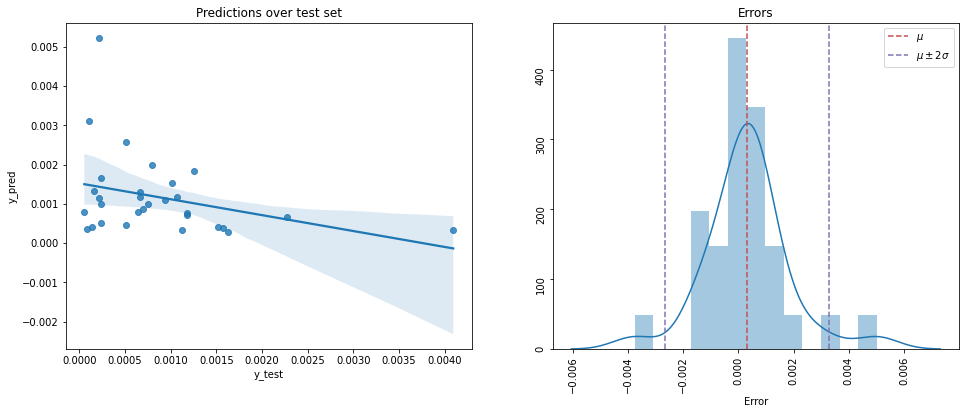

In [52]:
# error plots
err_test_mean = np.mean(err_test.flatten())
err_test_std = np.std(err_test.flatten())

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(x=y_test.flatten(), y=y_pred_test.flatten(), ax=ax[0])
ax[0].set(title='Predictions over test set', xlabel='y_test', ylabel='y_pred')

sns.distplot(a=err_test.flatten(), ax=ax[1])

ax[1].axvline(x=err_test_mean, color=sns.color_palette(palette='deep')[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=(err_test_mean + 2 * err_test_std), color=sns.color_palette(palette='deep')[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=(err_test_mean - 2 * err_test_std), color=sns.color_palette(palette='deep')[4], linestyle='--')

ax[1].set(title='Errors', xlabel='Error', ylabel='')
ax[1].tick_params(labelrotation=90)
ax[1].legend()